In [38]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

In [39]:
num_samples = 500
p1_range = [0, 1]
p2_range = [0, 1]


def f(p1, p2):
    return (p1 - 0.1) ** 2 + 4 * (p2 - 0.1) ** 2 - 0.64


def FI(df: pd.DataFrame) -> float:
    return len(df[df["label"] == 1]) / len(df)


# Generate a dataset
df = pd.DataFrame(columns=["p1", "p2", "f", "label"])
df["p1"] = np.random.uniform(p1_range[0], p1_range[1], num_samples)
df["p2"] = np.random.uniform(p2_range[0], p2_range[1], num_samples)
df["f"] = f(df["p1"], df["p2"])
df["label"] = (df["f"] < 0).astype(int)
df.drop("f", axis=1, inplace=True)

print(f"FI = {FI(df)}")

df.head()

FI = 0.366


,p1,p2,label
0,0.592976,0.178776,1
1,0.390277,0.017968,1
2,0.648951,0.271896,1
3,0.031121,0.551142,0
4,0.574524,0.217167,1


In [40]:
def train_cart(df: pd.DataFrame, label: str) -> DecisionTreeClassifier:
    cart = DecisionTreeClassifier()
    X = df.drop(columns=[label])
    y = df[label]
    
    # Define parameter grid
    param_grid = {
        'max_depth': np.arange(2, 12, 1),
        'min_samples_split': np.arange(0, int(len(df) * .8), 1),
        'min_samples_leaf': np.arange(1, int(len(df) * .8), 1),
    }
    
    search = RandomizedSearchCV(cart, param_grid, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1)
    search.fit(X, y)
    cart = search.best_estimator_
    print(f"Best parameters: {search.best_params_}")
    print(f"Best score: {search.best_score_}")
    return cart

In [41]:
cart = train_cart(df, "label")

Best parameters: {'min_samples_split': 157, 'min_samples_leaf': 41, 'max_depth': 11}
Best score: 0.9359999999999999


c:\Users\mexis\anaconda3\envs\main\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mexis\anaconda3\envs\main\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mexis\anaconda3\envs\main\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\mexis\anaconda3\envs\main\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\

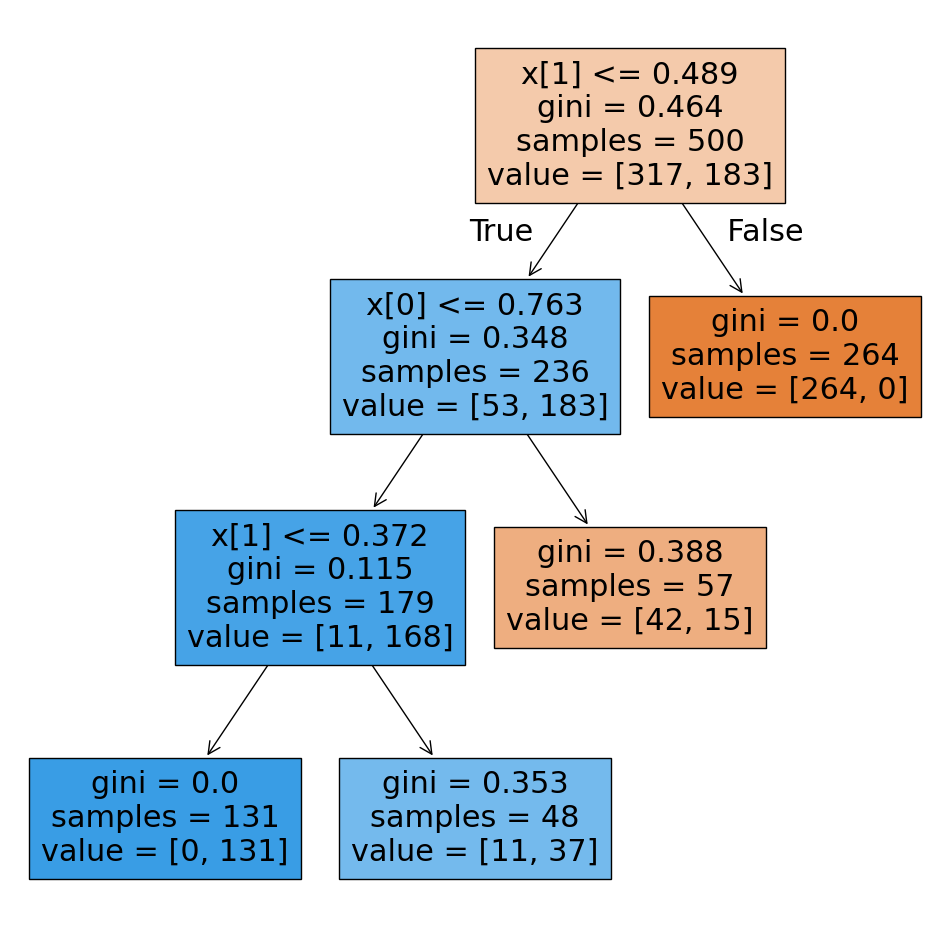

In [48]:
plt.figure(figsize=(12, 12))
plot_tree(cart, filled=True)
plt.show()

In [43]:
# Get the number of samples in the leaf nodes
rules = export_text(cart, feature_names=["p1", "p2"], spacing=1, decimals=4)

# From text to list
rules = rules.split("\n")
# FInd number of list elements that contain "class: "
leaf_nodes = [r for r in rules if "class:" in r]
leaf_nodes = [l.replace("|", "") for l in leaf_nodes]
leaf_nodes = [l.replace("-", "") for l in leaf_nodes]
leaf_nodes = [l.replace(" ", "") for l in leaf_nodes]
leaf_nodes = [l.replace("class:", "") for l in leaf_nodes]
leaf_nodes = [int(l) for l in leaf_nodes]
idx_leaf_nodes = [i for i, r in enumerate(rules) if "class:" in r]
# Relace '|' with '' 
rules = [r.replace("|", "") for r in rules]
rules = [r.replace("-", "") for r in rules]
# Replace spaces with ''
rules = [r.replace(" ", "") for r in rules]

# Define a dataframe to store the rules
rules_df = pd.DataFrame(columns=['feature', 'ineq', 'value', 'rule'])

start = 0
for id, i in enumerate(idx_leaf_nodes):
    ineq = []
    for r in rules[start:i]:
        if "<=" in r:
            ineq.append("<=")
        else:
            ineq.append(">")
    _ = [r.split("<=") if "<=" in r else r.split(">") for r in rules[start:i]]
    feature = [r[0] for r in _]
    value = [r[1] for r in _]
    rule = [id for _ in range(len(feature))]
    label = [leaf_nodes[id] for _ in range(len(feature))]
    # Append feature, value and rule to rules_df
    new_df = pd.DataFrame({'feature': feature, 'value': value, 'ineq': ineq, 'rule': rule, 'class': label})
    rules_df = pd.concat([rules_df, new_df], ignore_index=True)
    start = i+1

In [44]:
rules_df

,feature,ineq,value,rule,class
0,p2,<=,0.4889,0,1.0
1,p1,<=,0.7628,0,1.0
2,p2,<=,0.3721,0,1.0
3,p2,>,0.3721,1,1.0
4,p1,>,0.7628,2,0.0
5,p2,>,0.4889,3,0.0


In [54]:
_df = df[df['p2'] <= 0.489 ]
_df = _df[_df['p1'] <= 0.763]
_df = _df[_df['p2'] > 0.372]

_df['label'].value_counts(normalize=True)

label
1    0.77551
0    0.22449
Name: proportion, dtype: float64

In [46]:
from ml2rules.machinelearning import MyClass

my_class = MyClass(df, 'label', cart)
my_class.get_rules()
my_class.rules

['if (p2 > 0.489) then class: 0 (proba: 100.0%) | based on 264 samples',
 'if (p2 <= 0.489) and (p1 <= 0.763) and (p2 <= 0.372) then class: 1 (proba: 100.0%) | based on 131 samples',
 'if (p2 <= 0.489) and (p1 > 0.763) then class: 0 (proba: 73.68%) | based on 57 samples',
 'if (p2 <= 0.489) and (p1 <= 0.763) and (p2 > 0.372) then class: 1 (proba: 77.08%) | based on 48 samples']